## Relax, Inc. Coding Challenge
***

In [2]:
# Import Useful Tools for EDA
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

# Import necessary tools for feature prediction
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score

# Make plots pretty
sns.set()

In [2]:
#  Import both datasets
users = pd.read_csv('takehome_users.csv', encoding='latin1')
engage = pd.read_csv('takehome_user_engagement.csv')

# Peak inside users dataframe
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [3]:
# Check object types and null values in users dataframe.
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
object_id                     12000 non-null int64
creation_time                 12000 non-null object
name                          12000 non-null object
email                         12000 non-null object
creation_source               12000 non-null object
last_session_creation_time    8823 non-null float64
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            6417 non-null float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB


In [4]:
# Convert creation_time to datetime object.
users.creation_time = pd.to_datetime(users.creation_time)

# Assign numeric values to creation_source.
# Create dictionary of sources
c_sources = {'PERSONAL_PROJECTS':1, 'GUEST_INVITE':2, 'ORG_INVITE':3, 'SIGNUP':4,
            'SIGNUP_GOOGLE_AUTH':5}
users['creation_source'] = users['creation_source'].map(lambda s: c_sources[s])

# Convert last_session_creation_time to datetime object. Unix timestamp is in seconds.
users.last_session_creation_time = pd.to_datetime(users.last_session_creation_time, unit='s')

# Fill NaN last_session_creation_time with the creation time. 
users.last_session_creation_time.fillna(users.creation_time, inplace=True)

# Fill NaNs with 0 and convert invited_by_user_id to int.
users.invited_by_user_id.fillna(0, inplace=True)
users.invited_by_user_id= users.invited_by_user_id.astype(int)

In [5]:
# Confirm munging success.
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
object_id                     12000 non-null int64
creation_time                 12000 non-null datetime64[ns]
name                          12000 non-null object
email                         12000 non-null object
creation_source               12000 non-null int64
last_session_creation_time    12000 non-null datetime64[ns]
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            12000 non-null int32
dtypes: datetime64[ns](2), int32(1), int64(5), object(2)
memory usage: 890.7+ KB


In [6]:
# Print head of cleaned users dataframe.
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,2,2014-04-22 03:53:30,1,0,11,10803
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,3,2014-03-31 03:45:04,0,0,1,316
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,3,2013-03-19 23:14:52,0,0,94,1525
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,2,2013-05-22 08:09:28,0,0,1,5151
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,2,2013-01-22 10:14:20,0,0,193,5240


In [7]:
# Peak inside engage dataframe.
engage.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [8]:
# Check for null values and object types in engage dataframe.
engage.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
time_stamp    207917 non-null object
user_id       207917 non-null int64
visited       207917 non-null int64
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


In [9]:
# Convert time_stamp to a datetime object and confirm success.
engage.time_stamp = pd.to_datetime(engage.time_stamp)
engage.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
time_stamp    207917 non-null datetime64[ns]
user_id       207917 non-null int64
visited       207917 non-null int64
dtypes: datetime64[ns](1), int64(2)
memory usage: 4.8 MB


In [10]:
# View head of cleaned engaged dataframe.
engage.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [11]:
# Create array of unique user ids.
user_id = engage.user_id.unique()

# Instantiate adopted dictionary that will mark a user_id as 0 if not adopted and 1 if adobpted.
adopt_dict = {}

# Iterate through unique user_ids.
for ids in user_id:
    # If the total number of visits for the user id is less than 3 mark as not adopted (0) in the dictionary.
    if engage[engage.user_id==ids].visited.sum() <3:
        adopt_dict[ids]=0
    else:
        # Set is adopted indicator as false (0).
        is_adopt=0
        # Create a temporary dataframe of the time_stamps for the unique user_id and reset the index.
        temp = pd.DataFrame(engage[engage.user_id==ids].time_stamp.reset_index(drop=True))
        # Create value feature for each observation and set it to 1.
        temp['val']=1
        # Set the index of the temp dataframe to the time_stamps.
        temp.set_index('time_stamp', inplace=True)
        # Resample temp data frame to seven day period and get value counts for each 7 day period.
        weeks = temp.resample('W').count()
        # Iterate through values in the resample.  If a value is found that is greater than 3 is_adopt is set to True (1).
        for val in weeks.val:
            if val >=3:
                is_adopt = 1
        # Indicate the adoption status of the user id in the dictionary.
        adopt_dict[ids]=is_adopt
        

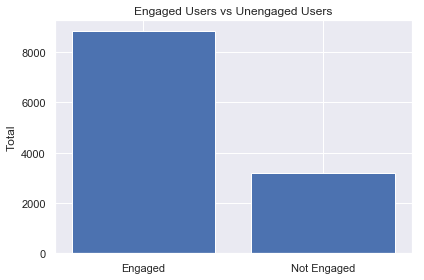

In [12]:
#  There seems to be many users in the user dataframe, that not in the engagement dataframe.  Investigating this further.
# Instantiate count object.
count=0

# Create array containing all of the unique user ides in the users dataframe.
all_users = users.object_id.unique()

#  Loop through series and count ids that are not found in the engagement dataframe.
for u in all_users:
    if u not in user_id:
        count+=1

# Create x and y axis
x = ['Engaged', 'Not Engaged']
y = [len(user_id),count]

#Plot chart.
plt.bar(x,y)
plt.title('Engaged Users vs Unengaged Users')
plt.ylabel('Total')
plt.tight_layout()
plt.show()

In [13]:
# Add unengaged users to adopted dictionary and set them to False(0)
for u in all_users:
    if u not in user_id:
        adopt_dict[u]=0


In [14]:
# Add adopted target feature to users dataframe. 0 = False, 1 = true.
users['adopted'] = users['object_id'].map(lambda s: adopt_dict[s])

# Review user datafraem with added feature.
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,2,2014-04-22 03:53:30,1,0,11,10803,0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,3,2014-03-31 03:45:04,0,0,1,316,1
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,3,2013-03-19 23:14:52,0,0,94,1525,0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,2,2013-05-22 08:09:28,0,0,1,5151,0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,2,2013-01-22 10:14:20,0,0,193,5240,0


In [15]:
# Instantiate X, y, and Xdata objects for hyperparameter tuning and feature analysis.
X = users.drop(['object_id','creation_time','name','email','last_session_creation_time','adopted'], axis=1).values
y = users.adopted.values
Xdata = users.drop(['object_id','creation_time','name','email','last_session_creation_time','adopted'], axis=1)

In [16]:
# Hyperparameter tune Random Forest Classifier.
# Instantiate RandomForestRegressor for hyperparameter tuning.
rfc = RandomForestClassifier(random_state=42)

# Dictionary of hyperparameters to tune.
params_rfc = {
    'max_depth':[1,2,3,4,5],
    'min_samples_leaf':[.02,.04,.06,.08,.1],
    'max_features':[.2,.4,.6,.8],
    'criterion':['gini', 'entropy']
}

#Instantiate GridSearch model.
grid_rfc = GridSearchCV(estimator=rfc,
                       param_grid = params_rfc,
                       cv = 5,
                       scoring = 'accuracy',
                       n_jobs=-1)

In [17]:
# Split data.    
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=.3, random_state=42)
  
# Fit training data
grid_rfc.fit(X_train,y_train)
    
# Predict on the test set and compute metrics
score = grid_rfc.best_score_
best = grid_rfc.best_estimator_
test_acc = best.score(X_test,y_test)
print('Best Parameters: \n',grid_rfc.best_params_)
print('Best CV Accuracy: {:.3f}'.format(score))
print('Best Test Accuracy: {:.3f}'.format(test_acc), '\n')

Best Parameters: 
 {'criterion': 'gini', 'max_depth': 1, 'max_features': 0.2, 'min_samples_leaf': 0.02}
Best CV Accuracy: 0.879
Best Test Accuracy: 0.880 



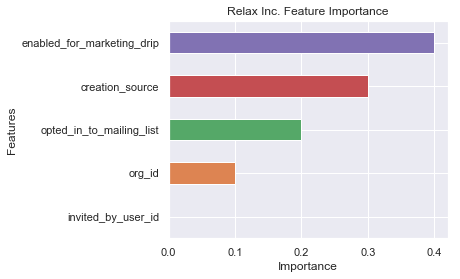

In [18]:
# Plotting important features.
# Instantiate RFClassifier using hyperparameters from tuning.
rfc= RandomForestClassifier(random_state=42,
                            criterion='gini',
                            max_depth=1,
                            max_features=.2,
                            min_samples_leaf=.02,
                            n_jobs=-1)

# Split data
Xd_train, Xd_test, yd_train, yd_test = train_test_split(Xdata,y, test_size=.3, random_state=42)

# Fit data
rfc.fit(Xd_train,yd_train)

# Get sorted feature importances
importances = pd.Series(rfc.feature_importances_, index=Xdata.columns).sort_values()

#Plot the sorted importances
_ = plt.subplots(1,1, figsize=(5,4))
_ = importances.plot(kind='barh')
_ = plt.title('Relax Inc. Feature Importance')
_ = plt.xlabel('Importance')
_ = plt.ylabel('Features')

plt.show()

In [19]:
# Get predictions from the current model.
y_pred = rfc.predict(Xd_test)

# Print confusion matrix and classification report.
print(confusion_matrix(yd_test, y_pred))
print(classification_report(yd_test,y_pred))

[[3169    0]
 [ 431    0]]
             precision    recall  f1-score   support

          0       0.88      1.00      0.94      3169
          1       0.00      0.00      0.00       431

avg / total       0.77      0.88      0.82      3600



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


The model does not predict a single adopted user. It appears there is likely a class weight issue.

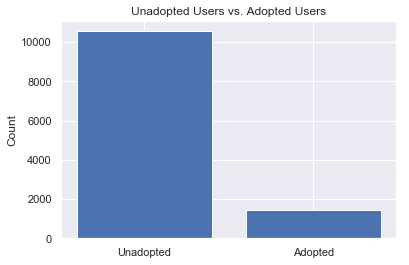

In [20]:
# Get labels and counts for unadopted and adopted users.
adopted, counts = np.unique(users.adopted, return_counts=True)

# Plot total number of adopted users vs unadopted users.
plt.bar(adopted, counts)
plt.xticks([0,1], ['Unadopted', 'Adopted'])
plt.title('Unadopted Users vs. Adopted Users')
plt.ylabel('Count')
plt.show()

In [21]:
# Import SMOTE to assist in fixing the imbalance of adopted users vs adopted users.
from imblearn.over_sampling import SMOTE

# Instantiate SMOTE model with default settings.
smote = SMOTE(random_state=42)

# Fit training data with SMOTE model.
Xs_train, ys_train = smote.fit_sample(Xd_train, yd_train)

In [22]:
# Instantiate new RFClassifier using hyperparameters from tuning.
rfc_smote= RandomForestClassifier(random_state=42,
                            criterion='gini',
                            max_depth=1,
                            max_features=.2,
                            min_samples_leaf=.02,
                            n_jobs=-1)



# Fit data
rfc_smote.fit(Xs_train,ys_train)

# Get new predictions using current model trained on SMOTE over-sampled training data.
y_pred = rfc_smote.predict(Xd_test)

# Print confusion matrix and classification report.
print(confusion_matrix(yd_test, y_pred))
print(classification_report(yd_test,y_pred))

[[1311 1858]
 [ 150  281]]
             precision    recall  f1-score   support

          0       0.90      0.41      0.57      3169
          1       0.13      0.65      0.22       431

avg / total       0.81      0.44      0.52      3600



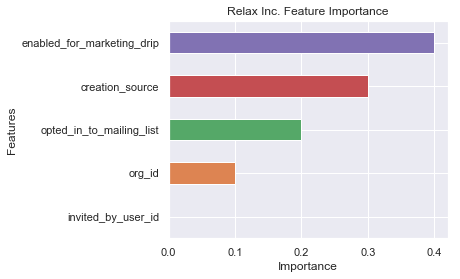

In [24]:
# Get sorted feature importances of updated model.
importances2 = pd.Series(rfc_smote.feature_importances_, index=Xdata.columns).sort_values()

#Plot the sorted importances
_ = plt.subplots(1,1, figsize=(5,4))
_ = importances2.plot(kind='barh')
_ = plt.title('Relax Inc. Feature Importance')
_ = plt.xlabel('Importance')
_ = plt.ylabel('Features')

plt.show()

The above graph indicates important features in predicting an adopted user.  The year and month of creation along with the year and month of last use were considered as additional features.  However, their relationship to adoption is self-evident and highly correlated.  Using said features drowned out the predictability importance of other features within the dataset.
<br><br>
In reviewing this data, I noticed there was a large amount of users in the user dataset that were not listed in the engagement dataset.  Additional research could be done on how features predict if a user will engage or not after initial sign-up.
<br><br>
Deeper research into the individual account creation sources could give more insight into adoption; it is a multinomial categorical feature and the second highest predictor of adoption. 